In [21]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [100]:
np.random.seed(2024)

In [101]:
dim = 1
n = 1000

x_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

y_sample = np.random.multivariate_normal(np.zeros((dim,)), np.eye(dim), n)

In [89]:
kernel = kernels.RBF(sigma_sq=2.)
mmd = metrics.MMD(kernel)
mmd(x_sample, y_sample)

0.4404960678194654

In [90]:
bootstrap = boot.WildBootstrap(mmd, ndraws=3)
pval = bootstrap.pval(x_sample, y_sample)

r [[ 1  1 -1 -1  1]
 [ 1 -1 -1 -1 -1]
 [ 1  1 -1  1 -1]]
ustat [[ 0.         -0.26524578 -0.18721834  0.06839145  0.0609132 ]
 [-0.26524578  0.          0.90322856 -0.32698786  0.18958225]
 [-0.18721834  0.90322856  0.         -0.10335017 -0.13947681]
 [ 0.06839145 -0.32698786 -0.10335017  0.         -0.36581532]
 [ 0.0609132   0.18958225 -0.13947681 -0.36581532  0.        ]]
mask [[[ 1  1 -1 -1  1]
  [ 1  1 -1 -1  1]
  [-1 -1  1  1 -1]
  [-1 -1  1  1 -1]
  [ 1  1 -1 -1  1]]

 [[ 1 -1 -1 -1 -1]
  [-1  1  1  1  1]
  [-1  1  1  1  1]
  [-1  1  1  1  1]
  [-1  1  1  1  1]]

 [[ 1  1 -1  1 -1]
  [ 1  1 -1  1 -1]
  [-1 -1  1 -1  1]
  [ 1  1 -1  1 -1]
  [-1 -1  1 -1  1]]]
boot_stats_mat [[[ 0.         -0.26524578  0.18721834 -0.06839145  0.0609132 ]
  [-0.26524578  0.         -0.90322856  0.32698786  0.18958225]
  [ 0.18721834 -0.90322856  0.         -0.10335017  0.13947681]
  [-0.06839145  0.32698786 -0.10335017  0.          0.36581532]
  [ 0.0609132   0.18958225  0.13947681  0.36581532  0.

In [73]:
def mmd_experiment(kernel_class, Xs, Ys, nboot=500):
    res = {
        "deviation": {"val": [], "threshold": [], "rej": []},
        "boot": {"val": [], "threshold": [], "pval": []},
    }

    for X, Y in tqdm(zip(Xs, Ys), total=Xs.shape[0]):
        kernel = kernel_class(sigma_sq=2.)
        mmd = metrics.MMD(kernel)
        val = mmd(X, Y)
        threshold = mmd.test_threshold(X.shape[0])
        # deviation bound
        rej = float(threshold < val)
        # bootstrap
        bootstrap = boot.WildBootstrap(mmd, ndraws=nboot)
        pval = bootstrap.pval(X, Y)

        # save results
        res["deviation"]["val"].append(val)
        res["deviation"]["threshold"].append(threshold)
        res["deviation"]["rej"].append(rej)
        
        res["boot"]["val"].append(val)
        res["boot"]["threshold"].append(threshold)
        res["boot"]["pval"].append(pval)

    return res

In [112]:
np.random.seed(2024)

In [113]:
nrep = 50
mean1 = np.zeros((dim,))
mean2 = np.zeros((dim,)) #+ 0.8

### Gaussian loc
Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

Ys = np.random.multivariate_normal(mean2, np.eye(dim), (nrep, n))
### Gaussian contam
# Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))

# eps = 0.01
# outlier = 10.
# mask = np.random.binomial(1, eps, (nrep, n))
# clean_samples = np.random.multivariate_normal(mean1, np.eye(dim), (nrep, n))
# Ys = np.where(np.expand_dims(mask, -1), np.ones_like(clean_samples) * outlier, clean_samples)
###

kernel_class = kernels.RBF

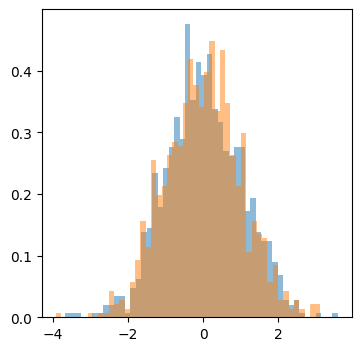

In [114]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
_ = ax.hist(Xs[0, :, 0], bins=50, label="X", alpha=0.5, density=True)
_ = ax.hist(Ys[0, :, 0], bins=50, label="Y", alpha=0.5, density=True)

In [115]:
res = mmd_experiment(kernel_class, Xs, Ys, nboot=200)

  0%|          | 0/50 [00:00<?, ?it/s]

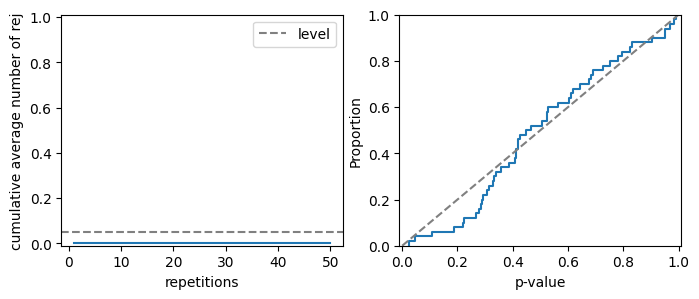

In [116]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

ax = axes[0]
ma = np.cumsum(res["deviation"]["rej"]) / (np.arange(nrep) + 1.)
ax.plot(np.arange(nrep) + 1., ma)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel("repetitions")
ax.set_ylabel("cumulative average number of rej")
_ = ax.legend()

ax = axes[1]
sns.ecdfplot(ax=ax, x=res["boot"]["pval"])
_ = ax.axline((0., 0.), slope=1., color="grey", linestyle="--")
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(0., 1.)
_ = ax.set_xlabel("p-value")

In [105]:
res2 = mmd_experiment(kernel_class, Xs, Ys, nboot=200)

  0%|          | 0/50 [00:00<?, ?it/s]

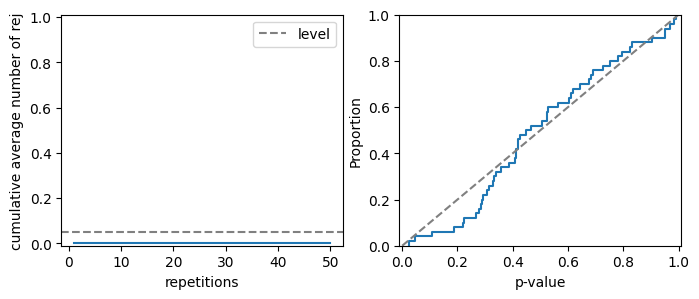

In [106]:
figs, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

ax = axes[0]
ma = np.cumsum(res2["deviation"]["rej"]) / (np.arange(nrep) + 1.)
ax.plot(np.arange(nrep) + 1., ma)
ax.axhline(0.05, color="grey", linestyle="--", label="level")
ax.set_ylim(-0.01, 1.01)
ax.set_xlabel("repetitions")
ax.set_ylabel("cumulative average number of rej")
_ = ax.legend()

ax = axes[1]
sns.ecdfplot(ax=ax, x=res2["boot"]["pval"])
_ = ax.axline((0., 0.), slope=1., color="grey", linestyle="--")
ax.set_xlim(-0.01, 1.01)
ax.set_ylim(0., 1.)
_ = ax.set_xlabel("p-value")